In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

# Local imports
from datasets import JunkFoodDataset
from qml import HybridQuantumCNN
from qml.ansatz import StandardQCNNAnsatz

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [3]:
# Configuration
data_folder = "data/data_noaug"

# Transform
IMAGE_SIZE = 64
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

dataset = JunkFoodDataset(data_folder, transform=transform)

print(f"Total images: {len(dataset)}")
print(f"Images with food: {sum(dataset.images[i]['has_food'] for i in range(len(dataset)))}")

Total images: 2196
Images with food: 1385


In [4]:
# Train/test split configuration
TRAIN_SPLIT = 0.8  # 80% for training
TEST_SPLIT = 0.2   # 20% for testing
BATCH_SIZE = 8
SEED = 42

# Calculate split sizes
total_size = len(dataset)
train_size = int(total_size * TRAIN_SPLIT)
test_size = total_size - train_size

# Split into train/test
random.seed(SEED)
indices = list(range(len(dataset)))
random.shuffle(indices)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total samples: {total_size}")
print(f"Train samples: {len(train_subset)} ({TRAIN_SPLIT*100:.0f}%)")
print(f"Test samples: {len(test_subset)} ({TEST_SPLIT*100:.0f}%)")

Total samples: 2196
Train samples: 1756 (80%)
Test samples: 440 (20%)


## Create Quantum CNN Model

In [5]:
# Model configuration
model = HybridQuantumCNN(
    kernel_size=8,
    stride=4,
    pool_size=8,
    encoding='dense',
    ansatz=StandardQCNNAnsatz(rotation_gate='rx'),
    measurement='z'
)

model = model.to(device)
print("Model created successfully!")

Using lightning.qubit device with 'dense' encoding, StandardQCNNAnsatz, measurement=PauliZ
Model created successfully!


## Setup Training

In [6]:
from notebooks.trainer import Trainer

# Training configuration
LEARNING_RATE = 0.001
EPOCHS = 10

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Create trainer
trainer = Trainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [7]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Epoch 1/10:   0%|          | 1/220 [00:39<2:22:46, 39.12s/it, acc=0.75, loss=0.673]


KeyboardInterrupt: 

## Train results

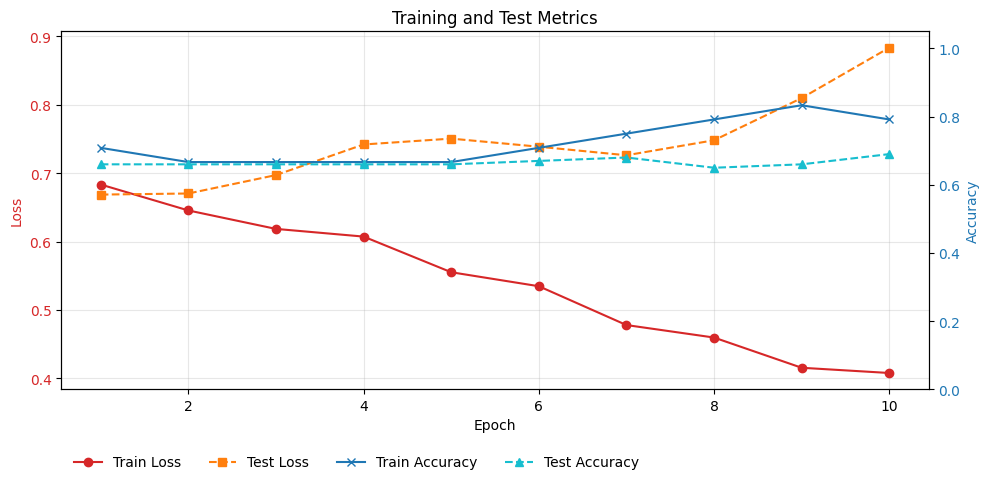

In [ ]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 13/13 [00:58<00:00,  4.47s/it]



Final Test Results:
Test Loss: 0.8836
Test Accuracy: 0.6900


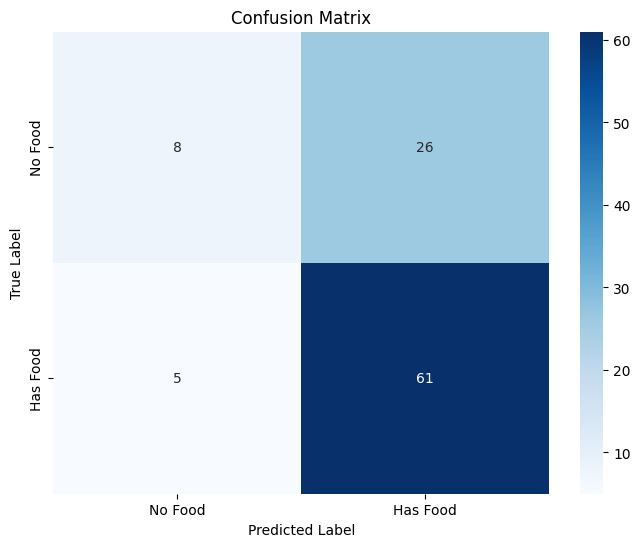


Detailed Metrics:
Precision: 0.7011
Recall: 0.9242
F1 Score: 0.7974

Confusion Matrix:
True Negatives:  8
False Positives: 26
False Negatives: 5
True Positives:  61


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Food', 'Has Food'], 
            yticklabels=['No Food', 'Has Food'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Print detailed metrics
tn, fp, fn, tp = confusion_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")